In [30]:
import numpy as np 
import pandas as pd 
from pandas import DataFrame 

import matplotlib.pyplot as plt 
import seaborn as sns
import itertools
%matplotlib inline

from datetime import datetime, timedelta 
from statsmodels.tsa.arima_model import ARIMA 

1. dailyhourlyMean()함수로 요일별, 시간별 평균 계산한 df_mean생성
2. for loop으로 df 칼럼별
<br>- dacon방식으로 직후 Null이 1개 이상 존재하는 인덱스 추출, 
<br>- df_mean에서 해당 Null시간에 따른 시간 평균 추출,
<br>- 시간별 가중치는 (해당시간 평균/null인 시간들의 평균 합)으로 계산
<br>- 누적치/null개수 * 가중치 
<br> : threshold보다 클 경우 그대로 입력, 그렇지 않을 경우 시간평균으로 대치

In [2]:
test = pd.read_csv("data/test.csv", sep = ",")
train = pd.read_csv("data/train.csv", sep =",")
submission = pd.read_csv("data/submission.csv")

In [3]:
def dailyhourlyMean(df):
    df['Time'] = pd.to_datetime(df.Time) ; df = df.set_index('Time')
    df['hour'] = df.index.hour ;  df['day'] = df.index.dayofweek

    return df.columns[:-2], df.groupby(['day','hour']).mean()

In [56]:
def DaconDHmeanPrep(df): #이 때 df는 아직 time Index가 안 되어있는 raw
    ids, df_mean = dailyhourlyMean(df)
    df1 = df
    for k in range(1,len(df.columns)):
        counting = df.loc[ df.iloc[:,k].isnull()==False ][ df.columns[k] ].index
        _id = pd.DataFrame(list(zip(counting[:-1], #값이 존재하는 index(시간) 중 마지막 제외
                          counting[1:]-counting[:-1] - 1)), # index 중 첫번째 제외 - 마지막 제외 - 1 : 각 인덱스 사이 구간에 얼마의 차이가 있는가, 즉 Null값이 몇개나 존재했는가
                 columns=['index','count'] )
        p005 = np.percentile(df.iloc[:,k].dropna(), 0.5)
        med = df.iloc[:,k].median()

        na_ids = _id[(_id['count'] >0)].reset_index(drop=True)
        if k%50 ==0: 
            print(k)
        for i, j in zip(na_ids['index'], na_ids['count']):
            initial = df.iloc[i,k]
            if initial > med:
                timeid = pd.to_datetime(df.iloc[i,0])
                timerange = timeid + pd.to_timedelta (np.arange(j+1), 'h')
                dh = [(t.dayofweek, t.hour) for t in timerange]
                means = df_mean.loc[dh, ids[k-1]]
                mean_tot = means.sum()
                weights = means/mean_tot
                w_values = weights*df.iloc[i,k]
                wv = pd.DataFrame(list(map(lambda x:x if x>p005 else np.nan, 
                                      df.iloc[i,k]*weights.values)))
                if np.isnan(wv.iloc[0,0]):
                    wv.iloc[0,0] = initial
                df1.iloc[i:i+j+1, k] = wv.values   
                # print('column ', ids[k-1], '| row', i, '| na count ',j,'\ntimerange ',timerange,'\nweights',weights, wv)
    df1['Time'] = pd.to_datetime(df1.Time) ; df1 = df1.set_index('Time') 
    return df1      

In [57]:
test2 = test.copy()
changed_test = DaconDHmeanPrep(test2)

50
100
150
200


### Arima get ready

In [36]:
from statsmodels.tsa.arima_model import ARIMA # ARIMA 모델

In [61]:
new_test = changed_test.dropna()
new_test.shape

(1275, 200)

In [75]:
new_test.head(2)

,X26,X303,X241,X435,X402,X352,X305,X350,X326,X299,...,X283,X329,X223,X266,X20,X443,X347,X75,X107,X230
Time,,,,,,,,,,,,,,,,,,,,,
2018-04-18 19:00:00,2.527,0.306,0.219,0.377,0.528,0.407,0.532,0.462,0.131,0.415,...,0.253,0.082,0.334,0.165,0.095,0.305,0.274,4.946,0.029,0.446
2018-04-18 20:00:00,2.641,0.396,0.216,0.389,0.630,0.302,0.349,0.511,0.139,0.363,...,0.186,0.081,0.256,0.790,0.093,0.327,0.351,2.877,0.030,0.443


In [62]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

In [63]:
time = []; place_id = []; target = []  

# test3 데이터프레임을 time인덱스, 미터ID(place_id)칼럼, 측정값(target)칼럼으로 정비
for i in new_test.columns:
    for j in range(len(new_test)):
        place_id.append(i)
        time.append(new_test.index[j])
        target.append(new_test[i].iloc[j])
new_test2 = pd.DataFrame({'place_id': place_id, 'time':time, 'target': target})
new_test2 = new_test2.dropna()
new_test2 = new_test2.set_index('time')
new_test2.head()

,place_id,target
time,,
2018-04-18 19:00:00,X26,2.527
2018-04-18 20:00:00,X26,2.641
2018-04-18 21:00:00,X26,2.368
2018-04-18 22:00:00,X26,1.899
2018-04-18 23:00:00,X26,1.956


In [59]:
def get_optimal_params(y):
    param_dict = {}
    for param in pdq:
        try:
            model = ARIMA(y, order=param)
            results_ARIMA = model.fit(disp=-1)
            param_dict[results_ARIMA.aic] = param
        except:
            continue

    min_aic = min(param_dict.keys())
    optimal_params = param_dict[min_aic]
    return optimal_params

In [86]:
# agg라는 dictionary를 생성하여, 각 미터ID를 key로, 예측시간 및 값 리스트를 value로 저장
agg={}
n = 0
hrs = [str(i+1) for i in range(24)]
for key in new_test2['place_id'].unique(): # 미터ID리스트를 unique()함수로 추출, for loop
    temp = new_test2.loc[new_test2['place_id']==key] # new_test2에서 key와 일치하는 place_id를 가지는 부분을 temp에 할당
    temp_1h=temp.resample('1h').sum() # 1시간 단위 resampling(일종의 timeseries압축)
    temp_1day=temp.resample('D').sum() # 1일 단위 resampling

    # 1 시간별 예측
    model = ARIMA(temp_1h['target'],  # target 을 추측하고자 함
                  order=get_optimal_params(temp_1h['target'])) # AIC를 최소화하는 최적의 파라미터 
    results_ARIMA = model.fit(disp=-1)  
    fcst = results_ARIMA.forecast(24) # 24시간 예측

    a = pd.DataFrame() # a: 예측값을 담을 데이터프레임 생성
    
    for i in range(24):
        a[str(i+1)]=[fcst[0][i]] # column명 지정 및 예측값 대입

    # a 에 meter_id를 현재 예측하고 있는 열의 id(key)로 대입
    a['meter_id'] = key 
    
    # agg{ 미터ID: 시간별(subimssion.columns는 예측시간칼럼들) a의 예측값}
    agg[key] = a[hrs]
    
    n+=1
    if n%100 ==0:
        print(n)
print('---- Modeling Done ----')

c:\users\soomin\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\soomin\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\soomin\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\soomin\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\soomin\appdata\local\programs\p

100


c:\users\soomin\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:221: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
c:\users\soomin\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\users\soomin\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\users\soomin\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\users\soomin\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: invalid value enco

200
---- Modeling Done ----


In [106]:
output1 = pd.concat(agg, ignore_index=False)
output2 = output1.T
output2.columns = output2.columns.droplevel(level = 1)
TEST_24h_pred = output2

In [107]:
TEST_24h_pred.to_csv("data/TEST_DHWonDacon_24시간예측")

# 메모리 에러 eghhh

In [24]:
## 내 컴에서는 메모리 에러
train2 = train.dropna(how='all', axis=1).copy()
changed_train = DaconDHmeanPrep(train2)

KeyError: MemoryError((1292, 16909), dtype('float64'))

In [41]:
changed_test.to_csv("data/test_DHWeight_onDacon.csv")
#changed_train.to_csv("data/train_DHWeight_onDacon.csv")

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

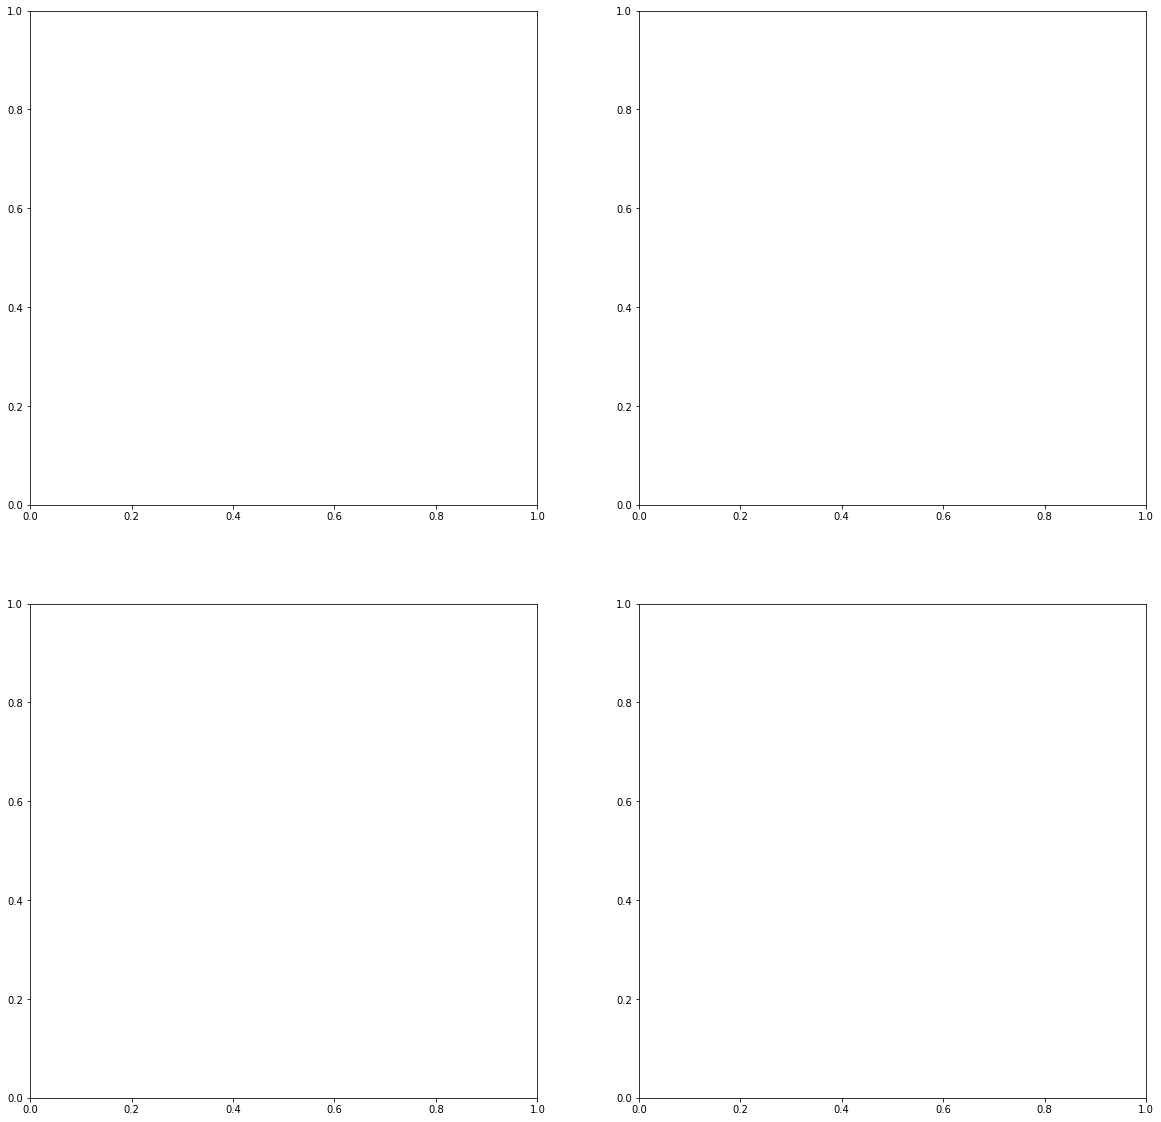

In [28]:
_, ax = plt.subplots(2,2, figsize=(20,20)) 

a=sns.distplot(test.isnull().mean(axis=0), ax=ax[0]) #나열된 값을 distplot을 이용해 시각화 하고, 이를 첫 번째 그래프 창에 넣습니다.
a.set(ylim=(0, 30))
ax[0].set_title('Distribution of Missing Values Percentage in Test set')

b=sns.distplot(changed_test.isnull().mean(axis=0), ax=ax[1]) #test data에서의 결측치 비율을 시각화 하고, 이를 두 번째 그래프 창에 넣습니다.
b.set(ylim=(0, 30))
ax[1].set_title('Distribution of Missing Values Percentage in Test set after Missing value processing')
plt.show()


a=sns.distplot(train.isnull().mean(axis=0), ax=ax[0]) #나열된 값을 distplot을 이용해 시각화 하고, 이를 첫 번째 그래프 창에 넣습니다.
a.set(ylim=(0, 30))
ax[0].set_title('Distribution of Missing Values Percentage in Test set')

b=sns.distplot(changed_train2.isnull().mean(axis=0), ax=ax[1]) #test data에서의 결측치 비율을 시각화 하고, 이를 두 번째 그래프 창에 넣습니다.
b.set(ylim=(0, 30))
ax[1].set_title('Distribution of Missing Values Percentage in Test set after Missing value processing')
plt.show()